In [1]:
import sys
sys.path.append("/Users/shvimas/Desktop/GitHub/diploma/src")

In [26]:
%matplotlib inline
import matplotlib.pyplot as pl
import data_helpers as dh
from data_helpers import read_data, array2str
import Heston_Pricing_Integral_vectorized as he
from pars_range import Range
from importlib import reload
dh = reload(dh)


pl.rcParams["figure.figsize"] = (15, 9)

In [3]:
pl.rcParams["figure.figsize"] = (15, 9)

In [24]:
try:
    data, info = read_data("../SPH2_031612.csv")
except FileNotFoundError:
    data, info = read_data("SPH2_031612.csv")

In [27]:
data, info = dh.prepare_data(data=data, info=info)

In [5]:
num = 20
kappa_range = Range(min=2, max=10, num=num)
theta_range = Range(min=1e-6, max=1, num=num)
sigma_range = Range(min=1e-6, max=1, num=num)
rho_range = Range(min=0, max=1, num=num)
v0_range = Range(min=1e-6, max=1, num=num)

In [20]:
day = 0
rate = .03
q = rate
maturity = info[day].mat / len(info)
spot = info[day].spot
is_call = True
strikes = data.strikes[is_call][day]
prices = data.prices[is_call][day]
    
strikes = strikes[:-10]
prices = prices[:-10]

args = (spot, strikes, maturity, rate, q, is_call)

In [8]:
pars = (4.2216740989, 0.0199176675743, 1.51769128617e-05, 0.0474806534178, 0.000569295223402)

kappa_range[0], *pars[1:]


(2.0, 0.0199176675743, 1.51769128617e-05, 0.0474806534178, 0.000569295223402)

In [9]:
predicted_kappa = []
kappas = kappa_range
for kappa in kappas:
    pars = kappa, *(pars[1:])
    x = strikes
    y = he.price_heston(pars=pars, args=args)
    predicted_kappa.append(x)
    predicted_kappa.append(y)

kappas[:]

[2.0,
 2.4210526315789473,
 2.8421052631578947,
 3.263157894736842,
 3.6842105263157894,
 4.105263157894736,
 4.526315789473684,
 4.947368421052632,
 5.368421052631579,
 5.789473684210526,
 6.2105263157894735,
 6.631578947368421,
 7.052631578947368,
 7.473684210526315,
 7.894736842105263,
 8.31578947368421,
 8.736842105263158,
 9.157894736842104,
 9.578947368421051,
 10.0]

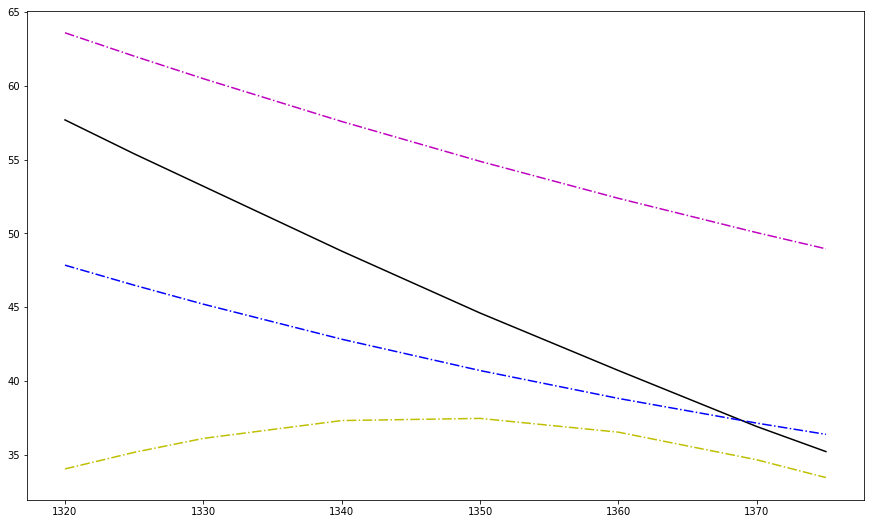

In [22]:
p = pl.plot(  # *predicted_kappa, 
    strikes, data.prices[is_call][day][:-10], "k-",
    strikes, he.price_heston(args=args, pars=(5.10944827e+00, 5.93251547e-03, 2.81152494e-05,
                                              4.93769921e-02, 1.01083722e-03)), "b-.",
    strikes, he.price_heston(args=args, pars=(5.22315635e-01, 2.66564927e-02, 1.08528697e-05,
                                              2.73492260e-01, 3.44132679e-03)), "m-.",
    strikes, he.price_heston(args=args, pars=(0.392416026657, 0.0060965246258, 0.855797208972, 
                                              1.0, 1e-10)), "y-.")

In [32]:
print(data.strikes[True][0])
print(data.prices[True][0])

[ 1320.  1325.  1330.  1340.  1350.  1360.  1370.  1375.  1380.  1390.
  1400.  1410.  1420.  1425.  1430.  1440.  1450.  1460.]
[ 57.7  55.4  53.2  48.8  44.6  40.7  36.9  35.2  33.4  30.1  27.1  24.2
  21.5  20.3  19.1  16.9  14.9  13. ]


In [6]:
from importlib import reload
import Heston_Pricing_Integral_vectorized as he
from structs import EvalArgs
import modeling
modeling = reload(modeling)
he = reload(he)

In [12]:
res = modeling.tune_model(args=EvalArgs.from_tuple(args),
                          model="heston", metric="RMR", prices=prices, 
                          bounds=((.1, 6), (.0001, .03), (1.5e-7, 3e-5), (0.035, 0.6), (5e-6, 5e-3)))


In [13]:
res

     fun: 1.6180050191343371
 message: 'Optimization terminated successfully.'
    nfev: 726
     nit: 7
 success: True
       x: array([  5.10944827e+00,   5.93251547e-03,   2.81152494e-05,
         4.93769921e-02,   1.01083722e-03])

In [15]:
res = modeling.tune_model(args=EvalArgs.from_tuple(args),
                          model="heston", metric="MAE", prices=prices, 
                          bounds=((.1, 6), (.0001, .03), (1.5e-7, 3e-5), (0.035, 0.6), (5e-6, 5e-3)))


In [16]:
res

     fun: 12.620299748890099
     jac: array([ 85.09225538, -11.67967199,  24.03531187,  46.86746617, -27.54035187])
 message: 'Optimization terminated successfully.'
    nfev: 1062
     nit: 9
 success: True
       x: array([  5.22315635e-01,   2.66564927e-02,   1.08528697e-05,
         2.73492260e-01,   3.44132679e-03])

In [11]:
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")


import data_helpers as dh
import numpy as np
import sklearn.decomposition as de


def plot_dots(a: np.ndarray, b: np.ndarray = None) -> None:
    a = a.flatten()
    if b is not None:
        b = b.flatten()
        pl.plot(a[::2], a[1::2], 'ro', b[::2], b[1::2], "bo")
    else:
        pl.plot(a[::2], a[1::2], 'ro')


centers = np.array(list(dh.extract_centers('params/best4heston_RMR.txt')))
print(centers)
centers = de.PCA(n_components=2).fit_transform(centers)
noised_normal = centers + np.random.normal(loc=(0, 0), scale=(.007, .002), size=centers.shape)
plot_dots(centers, noised_normal)

ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__